# **Task 7.1D Semi Gradient Sarsa $(0)$ and Semi Gradient TD $(\lambda)$**

## **Introduction**

In this task I implemented semi gradient sarsa(0) and semi gradient TD $(\lambda)$ on the environment Pendulum-v0 from Open AI Gym.

Both methods were implemented in Python notebook as seen further on in this report. They were implemented from scratch, excepting for the tiling
method which was adopted from [Richard S. Sutton](http://incompleteideas.net/tiles/tiles3.html). This was necessary due to the pendulum being a continous control 
problem, it was not realistic to represent the States via a tabular method. 

## **Methodology**

Both methods were implemented using tiling descritisation of the states, the sarsa method descritised the state action combinations to derive a Q state-action value function whilst 
the TD method I used a state-value V function only. Both methods made using of tile wrapping so that $0$ and $2\pi$ held the same state. this can be seen in the below code for functions
`featurise` (sarsa) and `featureise_TD` (TD). 

Both algorithms were trained over 100 episodes where with a maximum of 50 steps in each episode. The Episode could also end early depending on whether the Terminal state was reached (for the pendulum this was upright with zero velocity applied). The number of steps was chosen due to model limitations, since the weight object for both algorithms on large step counts, caused a stack overflow error due to numbers getting too negatively large. The only way to solve this was to normalise the weight vector between $[0,1)$ which showed some promise but had the added porblem where each step, the reward was not in the same numeric distribution as the weight vector so had to be scaled by division which was a rough aproximation, thus the current method was chosen.


The reward function for the Pendulum was slightly altered during testing as can be seen in the code such that 
```
        R = 1.0 / abs(R) if R != 0.0 else 1.0/0.001
```
The reward from the environment is negative ranging from $-16$ to $0.0$, this approach was decided on due to increase in overall performance (the algorithms were able to reach terminal control in Testing. 

Please see implementation for Sarsa $(0)$ under heading **Semi Gradient Sarsa $(0)$** and TD $(\lambda)$ under heading **Semi Gradient TD $(\lambda)$**.

For both the step size $\alpha$ and parameter $\gamma$ were set to $0.1$ and $0.99$ respectively and for TD method the trace decay $\lambda$ was set to $0.8$


## **Discussion**

Both algorithms showed some promise in learning, however TD $(\lambda)$ performed worse showing larger random behaviour and did not in the course of training and testing, reach terminal control of the pendulum. This can 
be seen in the report below in the Average Reward over 100 Episodes Chart as well as the result of the testing (see chart titled "Testing the reward in 2000 steps after training" for both algorithms). Sarsa can be show to have succeeded in some cases but was not able to converge consistently. i.e. under some starting conditions it was able to find the solution and hold the pendulum upright but under others it would only momentarily reach the terminal state before falling out of control. I believe this has to do with the nature of the control problem where the pendulum must follow rules of gravity it cannot simply steps itself to the final position, it must by definition make many steps of swinging back and forth to reach its point and then slow down. Due to this complexity and the fact that naturally the agent spends more time below its axis of rotation there is less time spent in the important state action combinations (sarsa) and states (TD lambda) for good learning and hence convergence. TD $(\lambda)$ also lost the ability to increase dimensionality but not storing the State-Action as a feature but rather only the value of the state and then in each case having to greedily try each action to decide which is best, since Sarsa explicitly stored the "correct behaviour" in the weight vector I think this assisted valuable states learning the right actions more efficiently. 


TD lambda differs from Sarsa in a key aspect in that it stores memory via the $\textbf{z}$ vector as seen in the code this is called the trace vector/eligibilty trace. This vector is is updated for each state on each step whilst only states visited often will be scaled this is done proportionally to the weight vector, hence we are in essence updating the past with the information we have in the present (this is seen as the backward view). I expected due to this "memory" (Zhang, 2022) that the TD method would outperfrom the Sarsa method due to possibly acting as a solution to the multi step complexity as discussed in the above paragraph. Another key difference between the method is the function used for learning. Sarsa uses a larger feature space of a Q value function which is a function of state, actions and the weight $Q(S, A, \textbf{w})$ whilst TD method only using a V value function which is a function of the state only $V(S, \textbf{w})$ as dicussed above I believe the Q value had some advantage in computation efficiency since we can practically call $argmax_{a}(Q)$ to get the best action over the weight vector rather than need to test the Reward from subsequent steps from the current state as in TD method.

## **Conclusion**

In conclusion, I was able to implement the two methods and practically show some of the difference between them. Unfortunately, clear results were not as forth coming as expected with the Sarsa finding the solution to indefinite control in some cases whilst the TD method not being able to do so at all. I think in the future more time can be spent trying to see if a solution for the stack overflow error on large step sizes can be found. Also to solve the problem of having less time to learn above the axis of rotation, artifical states can be set up to start the pendulum in the harder to reach states so that when it does get their in practise that it makes the correct decision rather than an exploration breaking the instable equilibrium.

## **References**

O'Neill, M., 2022. Reinforcement Learning Tutorial: Semi-gradient n-step Sarsa and Sarsa(λ) Theory and Implementation. [Blog] Michael O'Neill's ML Blog, Available at: <https://michaeloneill.github.io/RL-tutorial.html> [Accessed 6 May 2022].

Tanenbaum, L., 2022. ML Intro 6: Reinforcement Learning for non-Differentiable Functions. [online] Medium. Available at: <https://towardsdatascience.com/ml-intro-6-reinforcement-learning-for-non-differentiable-functions-c75e1464c6b9> [Accessed 6 May 2022].

Zhang, J., 2022. Reinforcement Learning — TD(λ) Introduction(2). [online] Medium. Available at: <https://meatba11.medium.com/reinforcement-learning-td-%CE%BB-introduction-2-f0ea427cd395> [Accessed 6 May 2022].

## **Coding Section**

In [1]:
# Testing
import gym
import numpy as np

import IPython

C:\Users\LukaCroote\AppData\Local\Programs\Python\Python310\lib\site-packages\gym\wrappers\monitoring\video_recorder.py:9: DeprecationWarning: The distutils package is deprecated and slated for removal in Python 3.12. Use setuptools or check PEP 632 for potential alternatives
  import distutils.spawn


In [89]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
# NOTE: Tiling software found in 
# http://incompleteideas.net/tiles/tiles3.py-remove

"""
Tile Coding Software version 3.0beta
by Rich Sutton
based on a program created by Steph Schaeffer and others
External documentation and recommendations on the use of this code is available in the 
reinforcement learning textbook by Sutton and Barto, and on the web.
These need to be understood before this code is.

This software is for Python 3 or more.

This is an implementation of grid-style tile codings, based originally on
the UNH CMAC code (see http://www.ece.unh.edu/robots/cmac.htm), but by now highly changed. 
Here we provide a function, "tiles", that maps floating and integer
variables to a list of tiles, and a second function "tiles-wrap" that does the same while
wrapping some floats to provided widths (the lower wrap value is always 0).

The float variables will be gridded at unit intervals, so generalization
will be by approximately 1 in each direction, and any scaling will have 
to be done externally before calling tiles.

Num-tilings should be a power of 2, e.g., 16. To make the offsetting work properly, it should
also be greater than or equal to four times the number of floats.

The first argument is either an index hash table of a given size (created by (make-iht size)), 
an integer "size" (range of the indices from 0), or nil (for testing, indicating that the tile 
coordinates are to be returned without being converted to indices).
"""

basehash = hash

class IHT:
    "Structure to handle collisions"
    def __init__(self, sizeval):
        self.size = sizeval                        
        self.overfullCount = 0
        self.dictionary = {}

    def __str__(self):
        "Prepares a string for printing whenever this object is printed"
        return "Collision table:" + \
               " size:" + str(self.size) + \
               " overfullCount:" + str(self.overfullCount) + \
               " dictionary:" + str(len(self.dictionary)) + " items"

    def count (self):
        return len(self.dictionary)
    
    def fullp (self):
        return len(self.dictionary) >= self.size
    
    def getindex (self, obj, readonly=False):
        d = self.dictionary
        if obj in d: return d[obj]
        elif readonly: return None
        size = self.size
        count = self.count()
        if count >= size:
            if self.overfullCount==0: print('IHT full, starting to allow collisions')
            self.overfullCount += 1
            return basehash(obj) % self.size
        else:
            d[obj] = count
            return count

def hashcoords(coordinates, m, readonly=False):
    if type(m)==IHT: return m.getindex(tuple(coordinates), readonly)
    if type(m)==int: return basehash(tuple(coordinates)) % m
    if m==None: return coordinates

from math import floor, log
from itertools import zip_longest

def tiles (ihtORsize, numtilings, floats, ints=[], readonly=False):
    """returns num-tilings tile indices corresponding to the floats and ints"""
    qfloats = [floor(f*numtilings) for f in floats]
    Tiles = []
    for tiling in range(numtilings):
        tilingX2 = tiling*2
        coords = [tiling]
        b = tiling
        for q in qfloats:
            coords.append( (q + b) // numtilings )
            b += tilingX2
        coords.extend(ints)
        Tiles.append(hashcoords(coords, ihtORsize, readonly))
    return Tiles

def tileswrap (ihtORsize, numtilings, floats, wrapwidths, ints=[], readonly=False):
    """returns num-tilings tile indices corresponding to the floats and ints, wrapping some floats"""
    qfloats = [floor(f*numtilings) for f in floats]
    Tiles = []
    for tiling in range(numtilings):
        tilingX2 = tiling*2
        coords = [tiling]
        b = tiling
        for q, width in zip_longest(qfloats, wrapwidths):
            c = (q + b%numtilings) // numtilings
            coords.append(c%width if width else c)
            b += tilingX2
        coords.extend(ints)
        Tiles.append(hashcoords(coords, ihtORsize, readonly))
    return Tiles


## **Semi Gradient Sarsa $(0)$**

In [73]:
# Semi Gradient Sarsa(0)
# Input: action-value-function q: S x A x R^d
# ALPHA and GAMMA
# value-function weights w which is legth d initialised to 0
# average reward estimate R 
# initialise S and A
# For loop indefinite
#               Take Action A and record S' and R
#               Choose A' as a funciton of q(S', dot, w) (epsilon-greedy)
#               w <- w + ALPHA x [R + GAMMA x q(S', A', w) - q(S, A, w)] x diff(S, A, w)
#               S <- S'
#               A <- A'
max_size = 2 ** 12
number_of_tiles = 10
# Action space
actions = np.arange(-2, 2.1, 0.1)
# Get index hash table
iht = IHT(max_size)
# Build weights vector which is same size as our index table (new state action space)
weights = np.zeros(max_size)

# Use tiles to featurise the state action space
def featurise(s, a, iht, num_tiles = 12):
    floats = s.copy()
    # scale observations
    floats[0] = floats[0] / (observation_range[1][0] - observation_range[0][0]) # x
    floats[1] = floats[1] / (observation_range[1][1] - observation_range[0][1]) # y
    floats[2] = floats[2] / (observation_range[1][2] - observation_range[0][2]) # velocity

    # Get tiles    
    action_index = np.argmin([abs(i - a) for i in actions])
    # features = tiles(iht, num_tiles, floats * num_tiles, [action_index])
    features = tileswrap(iht, num_tiles, floats * num_tiles, [num_tiles, False, False]
    , [action_index])
    # features = tiles(iht, num_tiles, [s * num_tiles, a])

    return features

# Function to get q value of given state action pair (q(S, A, w))
def get_value(s, a, w, num_tiles):

    features = featurise(s, a, iht, num_tiles)

    weights_ = w[features]

    return sum(weights_)


# Function to select best action (epsilon-greedy)
def get_best_action(s, w, env, num_tiles):
    score_pairs = [(a, get_value(s, a, w, num_tiles))  for a in actions]
    options = [i[0] for i in score_pairs if i[1] == max([val[1] for val in score_pairs])]

    chosen_action = np.random.choice(options, 1)
    return chosen_action


In [ ]:
# NOTE: We need to normalise the weights since it gets overflow quickly
# from github
# where `$\theta$` is the pendulum's angle normalized between *[-pi, pi]* (with 0 being in the upright position).
#    Based on the above equation, the minimum reward that can be obtained is 
# *-(pi<sup>2</sup> + 0.1 * 8<sup>2</sup> + 0.001 * 2<sup>2</sup>) = -16.2736044*

# DONE Adjust Gamma Down
# DONE Adjust Alpha Down
# DONE make each episode equal to 5000 steps
# DONE try wrap tiles

# Now run 
# NUM_EPISODES = 50
# NUM_STEPS = 100
NUM_EPISODES = 100
NUM_STEPS = 50
ALPHA = 0.1
GAMMA = 0.99
MAX_SIZE = 2 ** 12
NUMBER_OF_TILES = 52

env = gym.make('Pendulum-v1')
observation_range = (env.observation_space.low, env.observation_space.high)
actions = np.arange(-2, 2.01, 0.01)
iht = IHT(MAX_SIZE)
weights = np.zeros(MAX_SIZE)

reward = []
reward_vec = []
delta = 0
for ep in range(NUM_EPISODES):
    
    print('Episode: ', ep)

    old_obs = env.reset()
    action = get_best_action(old_obs, weights, env, NUMBER_OF_TILES) 

    steps = 0
    ep_reward = []
    positions = []
    while steps < NUM_STEPS:
        steps += 1
        # take action and observe S' and R
        obs, R, done, info = env.step(action)     
        actual_reward = R.copy()
        R = 1.0 / abs(R) if R != 0.0 else 1.0/0.001
        # Store observations
        positions.append(obs)
        # Store reward
        ep_reward.append(actual_reward)
        # Find greedy new action
        new_action = get_best_action(obs, weights, env, NUMBER_OF_TILES)
        # Get index of weights we are updating
        features = featurise(old_obs, action, iht, NUMBER_OF_TILES)
        # Check last few observations Call it quits if actually mnages to hold the position
        if abs(obs[0] - 1) < 1e-2 and abs(obs[1]) < 1e-2 and abs(obs[2]) < 1e-2:
            # Special case in terminal state
            print("Terminal: ", steps, obs)
            delta = (R - get_value(old_obs, action, weights, NUMBER_OF_TILES))
            weights[features] = weights[features] + ALPHA * delta
            # weights = (np.abs(weights)  - np.min(weights)) / (np.max(weights) - np.min(weights)) # This has the issue of normalised weights are imbalanced each time adjusted by R
            break

        
        delta = (R + GAMMA * get_value(obs, new_action, weights, NUMBER_OF_TILES) - get_value(old_obs, action, weights, NUMBER_OF_TILES))
        weights[features] = weights[features] + ALPHA * delta
        # Normalise Weights
        # weights = (np.abs(weights)  - np.min(weights)) / (np.max(weights) - np.min(weights)) # This has the issue of normalised weights are imbalanced each time adjusted by R

        old_obs = obs
        action = new_action

    reward_vec.append(ep_reward)
    reward.append((sum(ep_reward) / len(ep_reward), steps))
    

## **Result of Training**

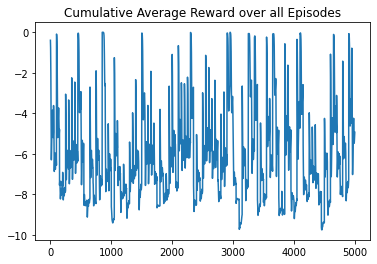

In [84]:
import matplotlib.pyplot as plt
reward_vec_cumulative = [np.cumsum(l) / np.cumsum([1] * len(l)) for l in reward_vec] 
flat_list = [item for sublist in reward_vec_cumulative for item in sublist]
plt.plot(flat_list)
plt.title("Cumulative Average Reward over all Episodes")
plt.show()

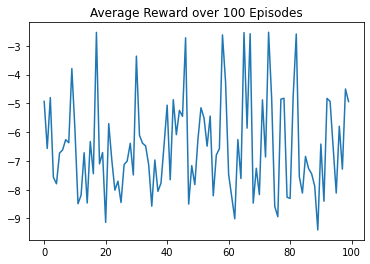

In [85]:
import matplotlib.pyplot as plt
# Average Reward over Total Episodes
plt.plot(list(range(len(reward))), [x[0] for x in reward])
plt.title("Average Reward over 100 Episodes")
plt.show()


## **Testing Sarsa $(0)$**

In [ ]:
# Testing
import gym
env = gym.make('Pendulum-v1')
obs = env.reset()
test_reward = []
for i in range(2000):
    env.render()
    action = get_best_action(obs, weights, env, NUMBER_OF_TILES)

    obs, R, _, _ = env.step(action)
    test_reward.append(R)
    print("Action: ", action, 'Obs: ', obs, 'Reward: ', R)
env.close()

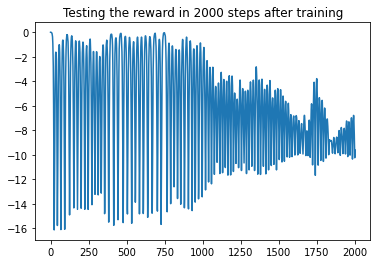

In [ ]:
# Testing Reward
plt.plot(test_reward)
plt.title('Testing the reward in 2000 steps after training')

import pickle
file_to_store = open("test_reward_success_2.pickle", "wb")
pickle.dump(test_reward, file_to_store)
file_to_store.close()

Text(0.5, 1.0, 'Successful Testing the reward in 2000 steps after training')

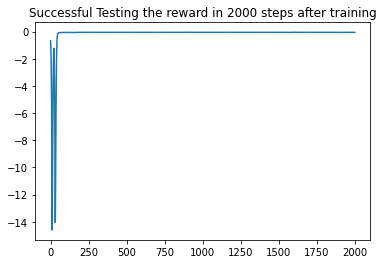

In [66]:
file_to_read = open("test_reward_success_1.pickle", "rb")
successful_test = pickle.load(file_to_read)
file_to_read.close()

plt.plot(successful_test)
plt.title('Successful Testing the reward in 2000 steps after training')

In [ ]:
# Testing
import gym
env = gym.make('Pendulum-v1')
obs = env.reset()
test_reward = []
for i in range(10000):
    env.render()
    action = get_best_action(obs, weights, env, NUMBER_OF_TILES)

    obs, R, _, _ = env.step(action)
    test_reward.append(R)
    print("Action: ", action, 'Obs: ', obs, 'Reward: ', R)
env.close()

# Testing Reward
plt.plot(test_reward)
plt.title('Testing the reward in 2000 steps after training')

## **Discussion**

Above we can see that Sarsa is able to converge on maintaining low variance on a state but only sometime (as seen directly above) find the terminal state and stay there

## **Semi Gradient TD $(\lambda)$**

In [67]:
# Semi Gradient TD Lambda

# Input: 
# feature function of State S x Rd
# policy to be evaluated

# Algorithm Parameter:
# step size ALPHA 
# trace decay LAMBDA
# weights w which is legth d initialised to 0

# Loop for each Episode
#       initialise S
#       x <- x(S)
#       reset z = 0
#       Loop for each step in the Episode until S = terminal
#               Choose action from Policy
#               Take action and observe R, S'
#               x' <- x(S')
#               V  <- wT x
#               V' <- wT x'
#               z <- GAMMA * LAMBDA * z + div V(S, w)
#               delta = R + GAMMA * V' - V
#               z <- GAMMA * LAMBDA * z + (1 - ALPHA * GAMMA  * LAMBDA * zT * x) * x 
#               w = w + ALPHA * delta * z 
#               S <- S'

# Make new verisons of above funcitons for TD version
# Use tiles to featurise the state action space
def featurise_TD(s, iht, num_tiles = 12):
    floats = s.copy()
    # scale observations
    floats[0] = floats[0] / (observation_range[1][0] - observation_range[0][0]) # x
    floats[1] = floats[1] / (observation_range[1][1] - observation_range[0][1]) # y
    floats[2] = floats[2] / (observation_range[1][2] - observation_range[0][2]) # velocity

    # Get tiles    
    # features = tiles(iht, num_tiles, floats * num_tiles)
    features = tileswrap(iht, num_tiles, floats * num_tiles, [num_tiles, False, False])

    return features

# Function to get q value of given state action pair (q(S, A, w))
def get_value_TD(s, w, num_tiles):
    features = featurise_TD(s, iht, num_tiles)
    weights_ = w[features]
    return sum(weights_)


def update_z(z, gamma, lam, features):
    # print(z)
    z *= gamma * lam
    z[features] += 1
    # print(z)
    return z

def get_action(env):    
    random_action = env.action_space.sample()
    return random_action 


# For this we need to manually calculate reward
# so that we dont update env when testing different acitons
# Reward and new state calculation stripped out of Pendulum class in AI Gym
def angle_normalize(x):
    return ((x + np.pi) % (2 * np.pi)) - np.pi

def calculate_reward(th, thdot, u):
  return -(angle_normalize(th) ** 2 + 0.1 * thdot ** 2 + 0.001 * (u ** 2))

def calculate_new_state(th, thdot, u, g=10.0, m=1.0, l=1.0, dt=0.05):
  newthdot = thdot + (3 * g / (2 * l) * np.sin(th) + 3.0 / (m * l ** 2) * u) * dt
  newthdot = np.clip(newthdot, -8.0, 8.0)
  newth = th + newthdot * dt  

  return((newth, newthdot))

def env_step(s, a):
    new_s = calculate_new_state(s[0], s[1], a)
    cost = calculate_reward(s[0], s[1], a)

    return np.array([np.cos(new_s[0]), np.sin(new_s[0]), new_s[1]], dtype=np.float32), -cost

# Function to select best action (epsilon-greedy)
# Here we need to compare the value of each
def get_best_action_TD(s, w, num_tiles):
    
    q_values = []
    for act in actions:
        o, rew = env_step(s, act)
        q_values.append(get_value_TD(o, w, num_tiles))
    
    index_of_best_action = np.argmax(q_values)
    best_action = actions[index_of_best_action]

    return [best_action]
        

In [ ]:
NUM_EPISODES = 100
NUM_STEPS = 50
ALPHA = 0.1
GAMMA = 0.99
LMBDA = 0.8
MAX_SIZE = 2 ** 12
NUMBER_OF_TILES = 52

env = gym.make('Pendulum-v1')
observation_range = (env.observation_space.low, env.observation_space.high)
actions = np.arange(-2, 2.01, 0.01)
iht = IHT(MAX_SIZE)
weights = np.zeros(MAX_SIZE)
z = np.zeros(MAX_SIZE)


reward = []
reward_vec = []
delta = 0
for ep in range(NUM_EPISODES):
    
    print('Episode: ', ep)

    old_obs = env.reset()
    # action = get_action(env) 
    action = get_best_action_TD(old_obs, weights, NUMBER_OF_TILES)
    steps = 0
    ep_reward = []
    positions = []

    while steps < NUM_STEPS:
        steps += 1
        # take action and observe S' and R
        obs, R, done, info = env.step(action)     
        actual_reward = R.copy()
        # R /= (16.2736044 * steps) # scale reward to fit better in normalised space This has some shortfalls thought (not quite correct)
        R = 1.0 / abs(R) if R != 0.0 else 1.0 / 0.001
        # Store observations
        positions.append(obs)
        # Store reward
        ep_reward.append(actual_reward)
        # Find greedy new action
        new_action = get_best_action_TD(obs, weights, NUMBER_OF_TILES)
        # Get index of weights we are updating
        features = featurise_TD(old_obs, iht, NUMBER_OF_TILES)

        z = update_z(z, GAMMA, LMBDA, features)
        # Check last few observations Call it quits if actually mnages to hold the position
        if abs(obs[0] - 1) < 1e-2 and abs(obs[1]) < 1e-2 and abs(obs[2]) < 1e-2:
            # Special case in terminal state
            print("Terminal: ", steps, obs)
            delta = (R - get_value_TD(old_obs, weights, NUMBER_OF_TILES))
            weights[features] = weights[features] + ALPHA * delta
            # weights = (np.abs(weights)  - np.min(weights)) / (np.max(weights) - np.min(weights)) 
            break

        delta = (R + GAMMA * get_value_TD(obs, weights, NUMBER_OF_TILES) - get_value_TD(old_obs, weights, NUMBER_OF_TILES))
        weights += ALPHA * delta * z
        # Normalise Weights
        # weights = (np.abs(weights)  - np.min(weights)) / (np.max(weights) - np.min(weights)) 
        # print(weights)
        action = get_best_action_TD(obs, weights, NUMBER_OF_TILES)
        old_obs = obs

    reward_vec.append(ep_reward)
    reward.append((sum(ep_reward) / len(ep_reward), steps))

## **Result of Training**

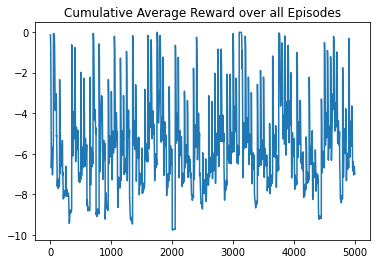

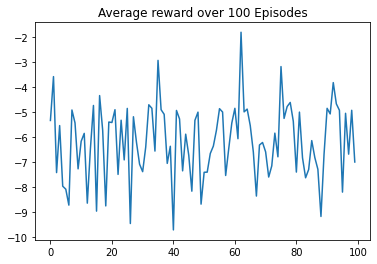

In [69]:
import matplotlib.pyplot as plt
reward_vec_cumulative = [np.cumsum(l) / np.cumsum([1] * len(l)) for l in reward_vec] 
flat_list = [item for sublist in reward_vec_cumulative for item in sublist]
plt.plot(flat_list)
plt.title("Cumulative Average Reward over all Episodes")
plt.show()

import matplotlib.pyplot as plt
# Average Reward over Total Episodes
plt.plot(list(range(len(reward))), [x[0] for x in reward])
plt.title("Average reward over 100 Episodes")
plt.show()


## **Testing TD $(\lambda)$**

In [ ]:
# Testing
import gym
env = gym.make('Pendulum-v1')
obs = env.reset()
test_reward_TD = []
for i in range(2000):
    env.render()
    action = get_best_action_TD(obs, weights, NUMBER_OF_TILES)

    # print(action)
    obs, R, _, _ = env.step(action)
    test_reward_TD.append(R)
    print("Action: ", action, 'Obs: ', obs, 'Reward: ', R)
    # print(obs, action)
env.close()

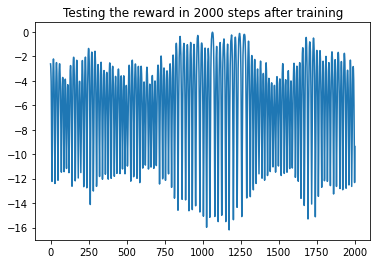

In [79]:
# Testing Reward
plt.plot(test_reward_TD)
plt.title('Testing the reward in 2000 steps after training')

import pickle
file_to_store = open("test_reward_TD_1.pickle", "wb")
pickle.dump(test_reward_TD, file_to_store)
file_to_store.close()


## **Discussion**

Compared to Sarsa, this method does not seem to be able to conver. On view the simulation it can be confrimed that after some time the Agent attempts to hold its position but fails with the magnitude of the force applied